## Import libraries

In [32]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.layers import Reshape

In [45]:
#Read dataset
df=pd.read_csv('1_percentage_of_source_dataset.csv')

In [46]:
df = df.drop('CAN ID', axis=1)

In [47]:
df

,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label
0,0,0,0,0,0,0,0,0,Dos
1,27,128,0,0,63,127,14,166,R
2,128,137,0,0,36,0,0,0,R
3,24,33,34,48,8,143,112,5,R
4,20,0,0,0,0,0,0,0,R
...,...,...,...,...,...,...,...,...,...
126207,254,78,0,0,0,60,0,0,R
126208,8,0,0,0,0,0,0,0,R
126209,254,73,0,0,0,60,0,0,R
126210,0,32,0,0,0,0,0,0,R


In [48]:
# The labels of the dataset. "R" indicates normal patterns, and there are four types of attack (DoS, fuzzy. gear spoofing, and RPM spoofing zttacks)
df.Label.value_counts()

R       107711
RPM       6584
gear      6017
Dos       5900
Name: Label, dtype: int64

In [49]:
# Transform all features into the scale of [0,1]
numeric_features = df.dtypes[df.dtypes != 'object'].index
scaler = QuantileTransformer() 
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [50]:
numeric_features

Index(['DATA[0]', 'DATA[1]', 'DATA[2]', 'DATA[3]', 'DATA[4]', 'DATA[5]',
       'DATA[6]', 'DATA[7]'],
      dtype='object')

In [51]:
df

,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Dos
1,0.689189,0.909910,0.000000,0.000000,0.727728,0.764264,0.824825,0.865365,R
2,0.815816,0.951952,0.000000,0.000000,0.637137,0.000000,0.000000,0.000000,R
3,0.652152,0.551051,0.641642,0.620621,0.466466,0.870370,0.916917,0.551552,R
4,0.599600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,R
...,...,...,...,...,...,...,...,...,...
126207,0.929930,0.811311,0.000000,0.000000,0.000000,0.675676,0.000000,0.000000,R
126208,0.515015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,R
126209,0.929930,0.804805,0.000000,0.000000,0.000000,0.675676,0.000000,0.000000,R
126210,0.000000,0.459960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,R


In [52]:
# Multiply the feature values by 255 to transform them into the scale of [0,255]
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x*255))

In [53]:
df

,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Dos
1,175.743243,232.027027,0.000000,0.000000,185.570571,194.887387,210.330330,220.668168,R
2,208.033033,242.747748,0.000000,0.000000,162.469970,0.000000,0.000000,0.000000,R
3,166.298799,140.518018,163.618619,158.258258,118.948949,221.944444,233.813814,140.645646,R
4,152.897898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,R
...,...,...,...,...,...,...,...,...,...
126207,237.132132,206.884384,0.000000,0.000000,0.000000,172.297297,0.000000,0.000000,R
126208,131.328829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,R
126209,237.132132,205.225225,0.000000,0.000000,0.000000,172.297297,0.000000,0.000000,R
126210,0.000000,117.289790,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,R


### Generate images for each class

In [54]:
df0=df[df['Label']=='R'].drop(['Label'],axis=1)
df1=df[df['Label']=='RPM'].drop(['Label'],axis=1)
df2=df[df['Label']=='gear'].drop(['Label'],axis=1)
df3=df[df['Label']=='Dos'].drop(['Label'],axis=1)
# df4=df[df['Label']=='Fuzzy'].drop(['Label'],axis=1)

In [55]:
df

,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Dos
1,175.743243,232.027027,0.000000,0.000000,185.570571,194.887387,210.330330,220.668168,R
2,208.033033,242.747748,0.000000,0.000000,162.469970,0.000000,0.000000,0.000000,R
3,166.298799,140.518018,163.618619,158.258258,118.948949,221.944444,233.813814,140.645646,R
4,152.897898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,R
...,...,...,...,...,...,...,...,...,...
126207,237.132132,206.884384,0.000000,0.000000,0.000000,172.297297,0.000000,0.000000,R
126208,131.328829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,R
126209,237.132132,205.225225,0.000000,0.000000,0.000000,172.297297,0.000000,0.000000,R
126210,0.000000,117.289790,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,R


In [56]:
df1

,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7]
80412,196.418919,171.531532,174.722222,255.0,171.403904,156.854354,0.0,255.0
80414,196.418919,171.531532,174.722222,255.0,171.403904,156.854354,0.0,255.0
80415,196.418919,171.531532,174.722222,255.0,171.403904,156.854354,0.0,255.0
80418,196.418919,171.531532,174.722222,255.0,171.403904,156.854354,0.0,255.0
80435,196.418919,171.531532,174.722222,255.0,171.403904,156.854354,0.0,255.0
...,...,...,...,...,...,...,...,...
126148,196.418919,171.531532,174.722222,255.0,171.403904,156.854354,0.0,255.0
126156,196.418919,171.531532,174.722222,255.0,171.403904,156.854354,0.0,255.0
126157,196.418919,171.531532,174.722222,255.0,171.403904,156.854354,0.0,255.0
126170,196.418919,171.531532,174.722222,255.0,171.403904,156.854354,0.0,255.0


In [62]:
# Generate 9*9 color images for class 0 (Normal)
# Change the numbers 9 to the number of features n in your dataset if you use a different dataset, reshape(n,n,3)
count=0
ims = []

image_path = "train/0/"
os.makedirs(image_path)

for i in range(0, len(df0)):  
    count=count+1
    if count<=24: 
        im=df0.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(8,8,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [63]:
# Generate 9*9 color images for class 1 (RPM spoofing)
count=0
ims = []

image_path = "train/1/"
os.makedirs(image_path)

for i in range(0, len(df1)):  
    count=count+1
    if count<=24: 
        im=df1.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(8,8,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [64]:
# Generate 9*9 color images for class 2 (Gear spoofing)
count=0
ims = []

image_path = "train/2/"
os.makedirs(image_path)

for i in range(0, len(df2)):  
    count=count+1
    if count<=24: 
        im=df2.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(8,8,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [65]:
# Generate 9*9 color images for class 3 (DoS attack)
count=0
ims = []

image_path = "train/3/"
os.makedirs(image_path)


for i in range(0, len(df3)):  
    count=count+1
    if count<=24: 
        im=df3.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(8,8,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

### Display samples for each category

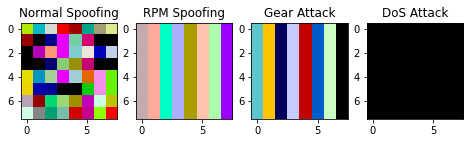

In [67]:
# Read the images for each category, the file name may vary (27.png, 83.png...)
img1 = Image.open('./train/0/24.png')
img2 = Image.open('./train/1/24.png')
img3 = Image.open('./train/2/24.png')
img4 = Image.open('./train/3/24.png')
# img5 = Image.open('./train/4/24.png')

plt.figure(figsize=(10, 10)) 
plt.subplot(1,5,1)
plt.imshow(img1)
plt.title("Normal Spoofing")
plt.subplot(1,5,2)
plt.imshow(img2)
plt.title("RPM Spoofing")
plt.subplot(1,5,3)
plt.imshow(img3)
plt.title("Gear Attack")
plt.subplot(1,5,4)
plt.imshow(img4)
plt.title("DoS Attack")

# plt.subplot(1,5,5)
# plt.imshow(img5)
# plt.title("Fuzzy Attack")
plt.show()  # display it

## Split the training and test set 

In [68]:
# Create folders to store images
Train_Dir='./train/'
Val_Dir='./test/'
allimgs=[]
for subdir in os.listdir(Train_Dir):
    for filename in os.listdir(os.path.join(Train_Dir,subdir)):
        filepath=os.path.join(Train_Dir,subdir,filename)
        allimgs.append(filepath)
print(len(allimgs)) # Print the total number of images

5047


In [69]:
#split a test set from the dataset, train/test size = 80%/20%
Numbers=len(allimgs)//5 	#size of test set (20%)

def mymovefile(srcfile,dstfile):
    if not os.path.isfile(srcfile):
#         print ("%s not exist!"%(srcfile))
        pass
    else:
        fpath,fname=os.path.split(dstfile)    
        if not os.path.exists(fpath):
            os.makedirs(fpath)               
        shutil.move(srcfile,dstfile)          
        #print ("move %s -> %s"%(srcfile,dstfile))

In [70]:
# The size of test set
Numbers

1009

In [71]:
# Create the test set
val_imgs=random.sample(allimgs,Numbers)
for img in val_imgs:
    dest_path=img.replace(Train_Dir,Val_Dir)
    mymovefile(img,dest_path)
print('Finish creating test set')

Finish creating test set


In [72]:
#resize the images 224*224 for better CNN training
def get_224(folder,dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for thisimg in imgs:
            thisimg_path=os.path.join(root,thisimg)
            imgfilepaths.append(thisimg_path)
    for thisimg_path in imgfilepaths:
        dir_name,filename=os.path.split(thisimg_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(thisimg_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

In [73]:
DATA_DIR_224='./train_224/'
get_224(folder='./train/',dstdir=DATA_DIR_224)

Finish resizing


In [74]:
DATA_DIR2_224='./test_224/'
get_224(folder='./test/',dstdir=DATA_DIR2_224)

Finish resizing


In [75]:
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
# from keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras
# from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
import math
import random
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [76]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 4038 images belonging to 4 classes.
Found 1009 images belonging to 4 classes.


In [77]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [78]:
history_this= LossHistory()

In [79]:
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten

def cnn_lstm_hybrid_model(num_class, epochs, history=history_this, input_shape=INPUT_SIZE):
    # Define the input layer
    input_layer = Input(shape=input_shape)
    
    # Define the CNN layer
    cnn_layer = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
    cnn_layer = MaxPooling2D(pool_size=(2, 2))(cnn_layer)
    cnn_layer = Conv2D(64, kernel_size=(3, 3), activation='relu')(cnn_layer)
    cnn_layer = Dropout(0.20)(cnn_layer)
    
    # Define the Flatten layer
    flatten_layer = Flatten()(cnn_layer)
    
    # Define the reshape layer
    gap_layer = GlobalAveragePooling2D()(cnn_layer)
    reshape_layer = Reshape((1, 64))(gap_layer)

    # Define the LSTM layer
    lstm_layer = LSTM(64, activation='relu')(reshape_layer)
    lstm_layer = Dropout(0.25)(lstm_layer)
    
    # Define the output layer
    output_layer = Dense(num_class, activation='softmax')(lstm_layer)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define the early stopping and model checkpoint callbacks
    early_stopping =kcallbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto')
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="./model", save_weights_only=True,
                                       monitor='val_accuracy', mode='max', save_best_only=True)
    
    # Train the model
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[early_stopping, model_checkpoint, history]
    )
    model.save("source_cnn_lstm_hybrid_final_model.h5")
    return history

In [83]:
hybrid_history = cnn_lstm_hybrid_model(num_class=4,epochs=7) #tf36cnn

Epoch 1/7
32/32 [==============================] - 151s 5s/step - loss: 0.9265 - accuracy: 0.8341 - val_loss: 0.6104 - val_accuracy: 0.8444
Epoch 2/7
32/32 [==============================] - 165s 5s/step - loss: 0.5765 - accuracy: 0.8559 - val_loss: 0.5393 - val_accuracy: 0.8444
Epoch 3/7
32/32 [==============================] - 168s 5s/step - loss: 0.4786 - accuracy: 0.8559 - val_loss: 0.4025 - val_accuracy: 0.8444
Epoch 4/7
32/32 [==============================] - 167s 5s/step - loss: 0.3351 - accuracy: 0.8826 - val_loss: 0.2613 - val_accuracy: 0.9009
Epoch 5/7
32/32 [==============================] - 164s 5s/step - loss: 0.2662 - accuracy: 0.9321 - val_loss: 0.2307 - val_accuracy: 0.9534
Epoch 6/7
32/32 [==============================] - 177s 6s/step - loss: 0.2237 - accuracy: 0.9460 - val_loss: 0.1539 - val_accuracy: 0.9534
Epoch 7/7
32/32 [==============================] - 167s 5s/step - loss: 0.1756 - accuracy: 0.9475 - val_loss: 0.1539 - val_accuracy: 0.9534


In [90]:
# hybrid_history = cnn_lstm_hybrid_model(num_class=5,epochs=5) #tf36cnn

In [84]:
hybrid_accuracy = hybrid_history.history['accuracy'][-1]
hybrid_loss = hybrid_history.history['loss'][-1]
hybrid_val_accuracy=  hybrid_history.history['val_accuracy'][-1]
hybrid_val_loss = hybrid_history.history['val_loss'][-1]
print("Accucacy:",round((hybrid_accuracy * 100),2),"%")
print("Loss:",round((hybrid_loss * 100),2),"%")
print("Val_Accucacy:",round((hybrid_val_accuracy * 100),2),"%")
print("Val_Loss:",round((hybrid_val_loss * 100),2),"%")

Accucacy: 94.75 %
Loss: 17.56 %
Val_Accucacy: 95.34 %
Val_Loss: 15.39 %


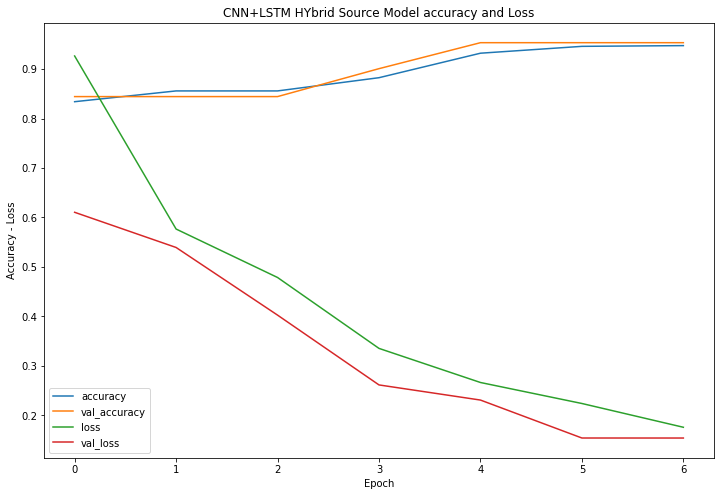

In [85]:
# Train and validation accuracy - loss
plt.figure(figsize=(12,8))
plt.plot(hybrid_history.history['accuracy'])
plt.plot(hybrid_history.history['val_accuracy'])
plt.plot(hybrid_history.history['loss'])
plt.plot(hybrid_history.history['val_loss'])
plt.title('CNN+LSTM HYbrid Source Model accuracy and Loss')
plt.ylabel('Accuracy - Loss')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy','loss', 'val_loss'])
plt.show()